# Problem 3 - Visualizing and Loading CIFAR-10

In [1]:
import pickle
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix as confusion
import pandas as pd
import seaborn as sn
%matplotlib inline

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def loadCIFAR10(folder):
    temp_data_set = unpickle("cifar-10-batches-py/" + "data_batch_1")
    train_Labels = list(temp_data_set.items())[1][1]
    train_feat = list(list(temp_data_set.items())[2][1])
    
    all_files = ["data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]

    for file in all_files:
        temp_data_set = unpickle("cifar-10-batches-py/" + file)
        new_labels = list(temp_data_set.items())[1][1]
        train_Labels = train_Labels + new_labels
        new_feat = list(list(temp_data_set.items())[2][1])
        train_feat = train_feat + new_feat
        
    test_data_set = unpickle("cifar-10-batches-py/test_batch")
    test_Labels = list(test_data_set.items())[1][1]
    test_feat = list(list(test_data_set.items())[2][1])
    
    return np.array(train_Labels), np.array(train_feat), np.array(test_Labels), np.array(test_feat)

In [4]:
# Load data
trainLabels, trainFeat, testLabels, testFeat = loadCIFAR10("cifar-10-batches-py/")

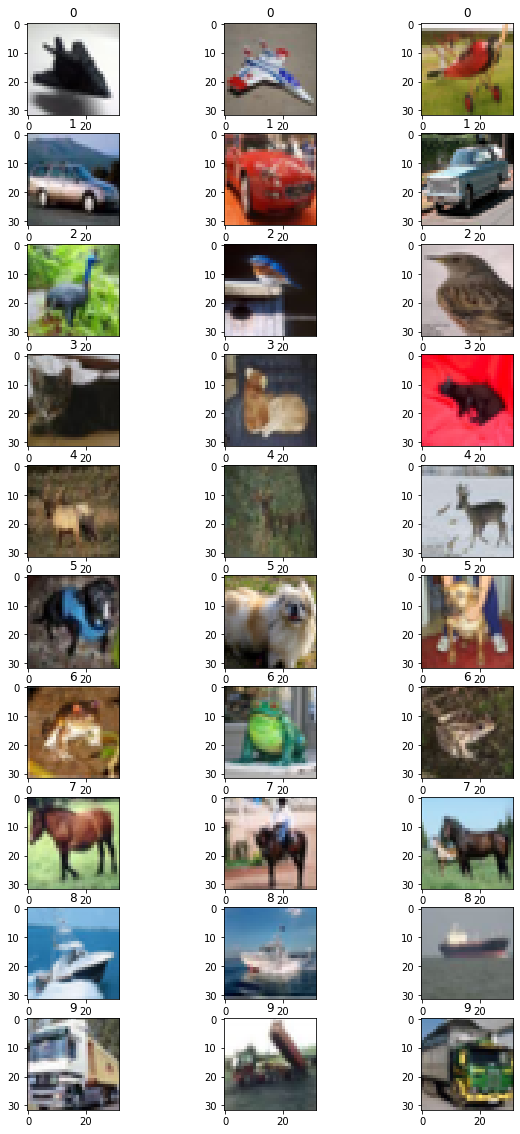

In [5]:
# Use loop to display the first three images from each of the10 categories
fig = plt.figure(figsize=(10,20))
for i in range(10):
    which_ones = np.where(trainLabels == i)
    for j in range(3):
        p = i * 3 + j + 1
        axes = fig.add_subplot(10, 3, p)
        pic = trainFeat[which_ones[0][j]]
        r = pic[:1024].reshape(32, 32)
        g = pic[1024:2048].reshape(32, 32)
        b = pic[2048:].reshape(32, 32)
        dis_pic = np.dstack((r, g, b))
        plt.imshow(dis_pic)
        axes.title.set_text(i)

# Problem 4 - Classifying Images

In [6]:
import numpy as np
from random import shuffle
from sklearn import preprocessing

In [7]:
# Function to normalize the features of the data
def normalize(train_data, test_data):
    # normalize
    # Subtract mean
    mean = np.mean(train_data, axis = 0)
    train_data = train_data - mean
    test_data = test_data - mean
    scaler = preprocessing.MinMaxScaler(feature_range = (-1, 1))
    train_data_nor = train_data/255 + 1e-15
    test_data_nor = test_data/255 + 1e-15
    return train_data_nor, test_data_nor

In [8]:
# One-hot function to make the labels into one-hot vector
def cifar_one_hot(labels):
    one_hot_labels = np.zeros((len(labels), 10))
    for i in range(len(labels)):
        one_hot_labels[i][int(labels[i]) - 1] = 1
    return one_hot_labels

In [9]:
# Forward pass function
def forward(x, weight):
    return np.dot(np.array(x), np.array(weight))

In [10]:
# Softmax function
def softmax(output_list):
    exp_output_list = np.exp(output_list - np.max(output_list))
    exp_output_list = exp_output_list * 1e200
    return exp_output_list/(np.sum(exp_output_list, axis = 1, keepdims = True) + 1e-15)

In [11]:
# Cross-entropy loss Function
def cross_entropy(data, pred, true_labels, weights, l2_weight_decay_factor):
    # With L2 regularization
    data = np.stack(data, axis = 0)
    loss = np.sum((- np.array(true_labels) * np.log(pred + 1e-15)))/len(true_labels) + l2_weight_decay_factor * np.linalg.norm(weights, 2)/2
    loss_grad = pred.copy()
    loss_grad = loss_grad - true_labels
    loss_grad = np.dot(data.T, loss_grad)
    loss_grad = loss_grad/len(true_labels)
    return loss, loss_grad

In [12]:
# Function to compute mean per-class accuracy
def computeMPC(pred, true_labels):
    prediction = np.zeros_like(pred)
    prediction[np.arange(len(pred)), pred.argmax(1)] = 1
    return np.sum(~(true_labels - prediction).any(1))/len(pred)

In [13]:
# Function to do stochastic gradient descent with mini-batches and momentum
def single_stochastic_gradient(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    
    iter_num = len(train_data)//mini_batch_size
    prev_grad = 0
    
    loss = 0
    for i in range(iter_num):
        new_pred = forward(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights)
        new_p = softmax(new_pred)
        new_loss, new_loss_grad = cross_entropy(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], new_p, train_labels_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights, l2_weight_decay_factor)
        loss = loss + new_loss
        # Find new weights
        weights = weights - momentum_rate * prev_grad - learning_rate * new_loss_grad
        prev_grad = new_loss_grad
        
    # For training data
    new_pred = forward(train_data_shuff, weights)
    new_p = softmax(new_pred)
    epoch_acc = computeMPC(new_p, train_labels_shuff)
    # For testing data
    test_new_pred = forward(test_data_shuff, weights)
    test_new_p = softmax(test_new_pred)
    test_loss, _ = cross_entropy(test_data_shuff, test_new_p, test_labels_shuff, weights, l2_weight_decay_factor)
    test_epoch_acc = computeMPC(test_new_p, test_labels_shuff)
    return epoch_acc, test_epoch_acc, weights, loss/iter_num, test_loss

In [14]:
# Returns the learned weights, the mean per class accuracy for each epoch for train and test,
# loss for each epoch for train and test
def train_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs):
    epoch_acc_list = []
    test_epoch_acc_list = []
    loss_list = []
    test_loss_list = []
    
    early_stop_count = 0
    for i in range(num_epochs):
        epoch_acc, test_epoch_acc, weights, loss, test_loss = single_stochastic_gradient(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor)
        epoch_acc_list.append(epoch_acc)
        test_epoch_acc_list.append(test_epoch_acc)
        loss_list.append(loss)
        test_loss_list.append(test_loss)
        if i%10 == 0:
            print(i, "epochs --- training accuracy:", round(epoch_acc, 6))

    return epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_loss_list

In [15]:
# Function to create the single layer neural network for softmax classifier
def main_cifar(train_zip, test_zip, param, num_epochs = 1000):
    # param = (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
    mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor = param
    
    cifar_train_labels, cifar_train_data = train_zip
    cifar_test_labels, cifar_test_data = test_zip
    cifar_train_data_normalized, cifar_test_data_normalized = normalize(cifar_train_data, cifar_test_data)
    cifar_train_labels_hot = cifar_one_hot(cifar_train_labels)
    cifar_test_labels_hot = cifar_one_hot(cifar_test_labels)
    
    # Initialize random weights
    weights = np.random.random((3072, 10))
    
    epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_lost_list = train_softmax(cifar_train_data_normalized, cifar_train_labels_hot, cifar_test_data_normalized, cifar_test_labels_hot, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs)
    
    test_pred = forward(cifar_test_data_normalized, weights)
    test_p = softmax(test_pred)
    test_prediction = test_p.argmax(1)
    
    return epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_lost_list, test_prediction

In [16]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
param = (1000, 0.05, 0.01, 0.2)
epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_loss_list, test_prediction = main_cifar((trainLabels, trainFeat), (testLabels, testFeat), param, 300)

0 epochs --- training accuracy: 0.16516
10 epochs --- training accuracy: 0.27628
20 epochs --- training accuracy: 0.34182
30 epochs --- training accuracy: 0.33952
40 epochs --- training accuracy: 0.34024
50 epochs --- training accuracy: 0.34998
60 epochs --- training accuracy: 0.35848
70 epochs --- training accuracy: 0.36748
80 epochs --- training accuracy: 0.37342
90 epochs --- training accuracy: 0.38012
100 epochs --- training accuracy: 0.38506
110 epochs --- training accuracy: 0.38816
120 epochs --- training accuracy: 0.39066
130 epochs --- training accuracy: 0.39526
140 epochs --- training accuracy: 0.39886
150 epochs --- training accuracy: 0.4013
160 epochs --- training accuracy: 0.40546
170 epochs --- training accuracy: 0.40816
180 epochs --- training accuracy: 0.41004
190 epochs --- training accuracy: 0.41212
200 epochs --- training accuracy: 0.41324
210 epochs --- training accuracy: 0.4155
220 epochs --- training accuracy: 0.41788
230 epochs --- training accuracy: 0.41896
240 e

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

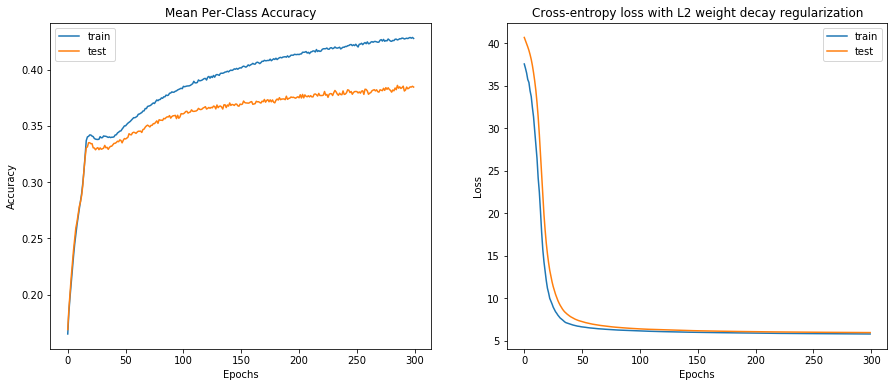

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(epoch_acc_list)), epoch_acc_list)
_ = ax1.plot(np.arange(len(test_epoch_acc_list)), test_epoch_acc_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("Mean Per-Class Accuracy")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("Accuracy")

_ = ax2.plot(np.arange(len(loss_list)), loss_list)
_ = ax2.plot(np.arange(len(loss_list)), test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Cross-entropy loss with L2 weight decay regularization")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Loss")

In [19]:
max(test_epoch_acc_list)

0.3859

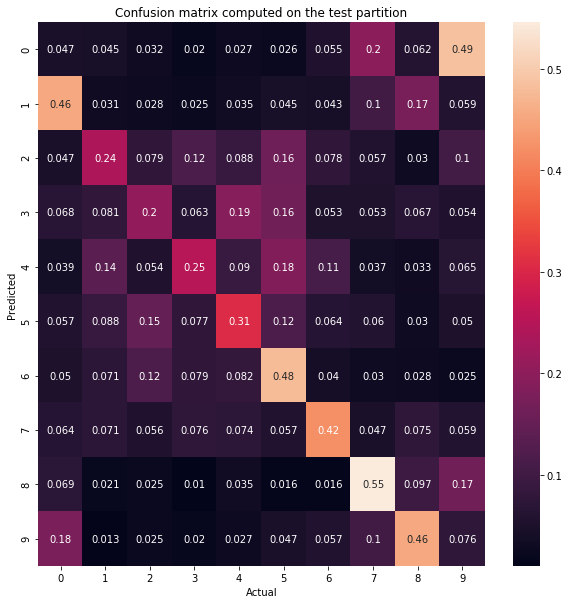

In [20]:
# Making a confusion matrix
conf = confusion(testLabels, test_prediction, normalize = 'true')
_ = plt.figure(figsize = (10, 10))
sn.heatmap(conf, annot=True)
_ = plt.title("Confusion matrix computed on the test partition")
_ = plt.ylabel("Predicted")
_ = plt.xlabel("Actual")